In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

In [2]:
from einops import rearrange

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
import sys
sys.path.append("../")
from simulator.lensing import LensingSim

In [5]:
from urllib import request
import gzip
import pickle

filename = [
["training_images","../data/train-images-idx3-ubyte.gz"],
["test_images","../data/t10k-images-idx3-ubyte.gz"],
["training_labels","../data/train-labels-idx1-ubyte.gz"],
["test_labels","../data/t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("../data/mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("../data/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

# download_mnist()
# save_mnist()

mnist_sq = rearrange(load()[0], 'b (h w) -> b h w', h=28)

In [6]:
cmap = 'coolwarm'

In [7]:
# Don't worry about these
exposure = 1610.0
n_xy = 96
pixel_size = 0.1
mag_zero=25.5
mag_iso=310.5
mag_s = 26.5
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = LensingSim._mag_to_flux(mag_iso, mag_zero)
S_tot = LensingSim._mag_to_flux(mag_s, mag_zero)

observation_dict = {
    "n_x": n_xy,
    "n_y": n_xy,
    "theta_x_lims": (-coordinate_limit, coordinate_limit),
    "theta_y_lims": (-coordinate_limit, coordinate_limit),
    "exposure": exposure,
    "f_iso": f_iso,
}

### Can play around with changing these ###

# Size of source
theta_s_e = 0.8

# Redshift (distance) of source and lens
global_dict = {"z_s": 1., "z_l": 0.2}

# theta_x_0 and theta_y_0 are the position of lens, theta_E is its size, q is its ellipticity
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}

###########################################

src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": theta_s_e,"n_srsc": 1}    

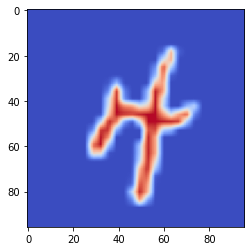

In [8]:
from skimage.transform import rescale, resize, downscale_local_mean

mnist_resized = resize(mnist_sq[342], (n_xy, n_xy),
                       anti_aliasing=True)

plt.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)

In [9]:
# # Lensed image

# lens_list = [hst_param_dict]
        
# lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
# image = lsi.lensed_image()

# plt.imshow(image)

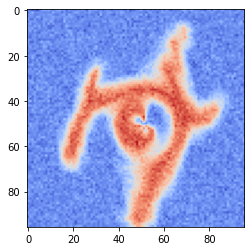

In [10]:
# Change the lens position

src_param_dict = {"profile": "CartesianGrid", "src_ary": mnist_resized} 
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.3, "theta_y_0": 0.4, "theta_E": 1.5, "q": 0.7}

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image() 
image += np.random.randn(*image.shape)

plt.imshow(image.T, cmap=cmap)

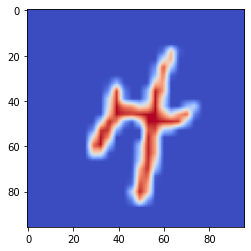

In [11]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image_nolens = jnp.nan_to_num(lsi.lensed_image())

plt.imshow(image_nolens.T, cmap=cmap)

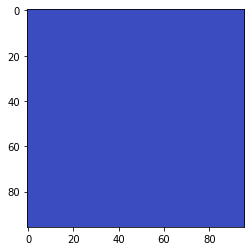

In [12]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [], global_dict, observation_dict)
image_nosrc = lsi.lensed_image()

plt.imshow(image_nosrc, cmap=cmap)

In [13]:
np.mean(image_nolens - image_nosrc), np.std(image_nolens - image_nosrc)

(DeviceArray(1.30251076, dtype=float64),
 DeviceArray(3.52514032, dtype=float64))

In [14]:
np.mean(mnist_resized), np.std(mnist_resized)

(0.0809012895748939, 0.21895281489513563)

## Custom source

In [15]:
import sys
sys.path.append("../")

from simulator.profiles import LightProfileSersic

In [16]:
# theta_x_lims = theta_y_lims = [-1.5, 1.5]
# n_x = n_y = 64

# theta_x, theta_y = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_x), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_y))

# inputs = LightProfileSersic(x_0=0.3, y_0=0., S_tot=5., r_e=1., n_srsc=4,).flux(theta_x, theta_y)

In [17]:
from jax import vmap
from einops import rearrange, repeat

In [18]:
# Lensed image

def render_lens(inputs):
    lens_list = [hst_param_dict]
    src_param_dict = {"profile": "CartesianGrid", "src_ary": inputs}    

    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    
    return image


# image = render_lens(inputs)

# plt.imshow(image)

In [19]:
render_lens_vmapped = vmap(render_lens)

# render_lens_vmapped(repeat(inputs, "h w -> b h w", b=128)).shape

## NeRF

In [405]:
def positional_encoding(inputs, positional_encoding_dims=6):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [406]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [407]:
num_dense_layers = 8
dense_layer_width = 256
add_positional_encoding = True
add_skip_connection = True

In [408]:
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        for i in range(num_dense_layers):
            # Apply positional encoding to the input points
            
            if add_positional_encoding:
                x = positional_encoding(input_points)
            else:
                x = input_points
                        
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.gelu(x)
            
            if add_skip_connection:
                # Skip connection
                x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x

        x = nn.Dense(1, dtype=self.dtype)(x)
        return x


In [409]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [410]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(43))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

In [411]:
# input_to_network = jnp.ones((1, 2 * n_xy * n_xy))
input_to_network = jnp.ones((n_xy * n_xy, 2))

In [412]:
model.apply({"params": params}, input_to_network).shape

(9216, 1)

In [413]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_leaves(params)))

'The model has 55553 parameters'

In [414]:
theta_x_lims = theta_y_lims = [-1., 1.]
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)

In [415]:
coords.shape

(2, 96, 96)

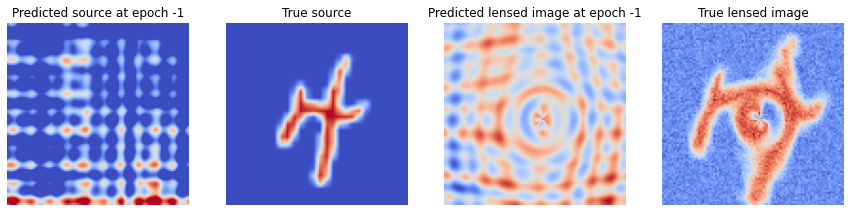

In [416]:
model_fn = lambda x: model.apply({"params": params}, x)
# model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
model_output = model_fn(rearrange(coords, "c h w -> (h w) c"))
model_output = rearrange(model_output, "(h w) 1 -> 1 h w", h=n_xy, w=n_xy)

lenses = render_lens_vmapped(model_output)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

epoch = -1

ax1.imshow(model_output[0], cmap=cmap, vmin=0, vmax=1)
ax1.set_title(f"Predicted source at epoch {epoch}")
ax1.axis("off")
ax2.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)
ax2.set_title(f"True source")
ax2.axis("off")
ax3.imshow(lenses[0].T, cmap=cmap)
ax3.set_title(f"Predicted lensed image at epoch {epoch}")
ax3.axis("off")
ax4.imshow(image_input[0].T, cmap=cmap)
ax4.set_title(f"True lensed image")
ax4.axis("off")
plt.show()

In [417]:
def train_step(state, batch):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
                       
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output = model_fn(inputs)
        model_output = rearrange(model_output, "(h w) 1 -> 1 h w", h=n_xy, w=n_xy)

        lenses = render_lens_vmapped(model_output)
        
        # Compute mean-squared error
        loss_mse = jnp.mean((lenses - targets) ** 2)
        return loss_mse
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state 

In [418]:
learning_rate = 1e-3
weight_decay = 1e-5
momentum = 0.8
optimizer = "adamw"

In [419]:
train_epochs = 2000

In [420]:
coords.shape, image_input.shape

((2, 96, 96), (1, 96, 96))

In [421]:
from celluloid import Camera

# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(42))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

# Define the Optimizer
if optimizer == "adamw":
    optimizer = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
elif optimizer == "sgdm":
    optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum, nesterov=True)
else:
    raise NotImplementedError
    
# Create the Training State
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)


# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn):
        
    train_loss_history, train_psnr_history, reconstructed_lens_history, reconstructed_src_history = [], [], [], []
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        train_loss, train_psnr, state = train_step_fn(state, train_batch)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % 50 == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) 1 -> 1 h w", h=n_xy, w=n_xy)
            
            lenses = render_lens_vmapped(model_output)
            
            reconstructed_lens_history.append(np.asarray(lenses[0].T))
            reconstructed_src_history.append(np.asarray(model_output[0]))
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
            
            ax1.imshow(model_output[0], cmap=cmap, vmin=0, vmax=1)
            ax1.set_title(f"Predicted source at epoch {epoch}")
            ax1.axis("off")
            ax2.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)
            ax2.set_title(f"True source")
            ax2.axis("off")
            ax3.imshow(lenses[0].T, cmap=cmap)
            ax3.set_title(f"Predicted lensed image at epoch {epoch}")
            ax3.axis("off")
            ax4.imshow(image_input[0].T, cmap=cmap)
            ax4.set_title(f"True lensed image")
            ax4.axis("off")
            plt.show()
    
    history = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src": reconstructed_src_history
    }
    
    return state, history, cam

  0%|          | 0/2000 [00:00<?, ?it/s]

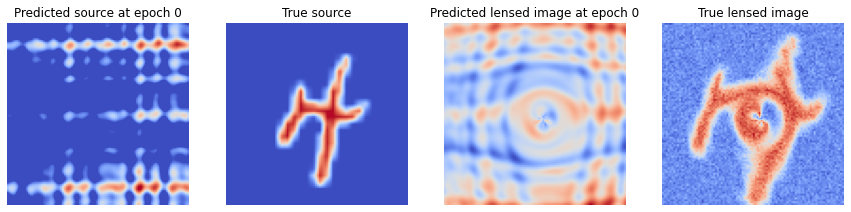

  2%|▎         | 50/2000 [00:40<23:40,  1.37it/s] 

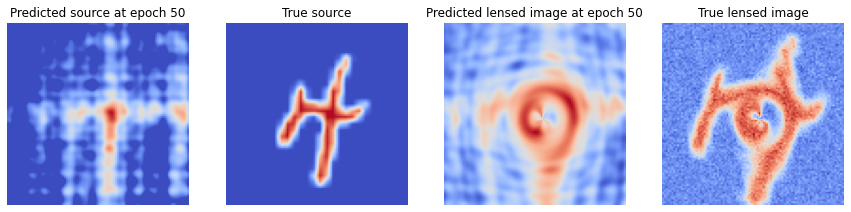

  5%|▌         | 100/2000 [01:18<24:15,  1.31it/s]

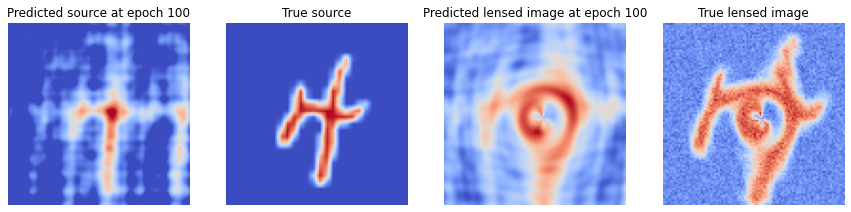

  8%|▊         | 150/2000 [01:56<22:48,  1.35it/s]

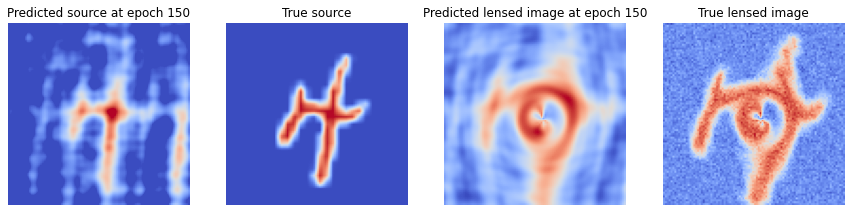

  9%|▊         | 172/2000 [02:14<23:44,  1.28it/s]


KeyboardInterrupt: 

In [422]:
state, history, cam = train_and_evaluate(state, train_step)

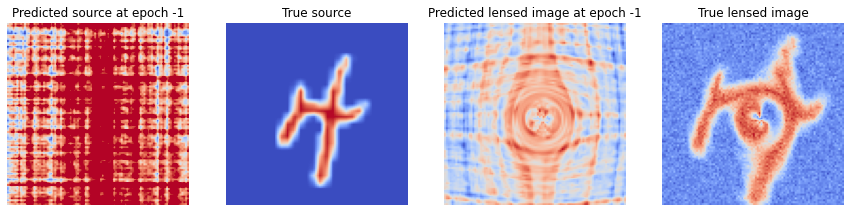

In [326]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
camera = Camera(fig)

for i in range(len(history["reconstructed_lens"])):
    ax1.imshow(history["reconstructed_src"][i], cmap=cmap, vmin=0, vmax=1)
    ax1.set_title(f"Predicted source at epoch {epoch}")
    ax1.axis("off")
    ax2.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)
    ax2.set_title(f"True source")
    ax2.axis("off")
    ax3.imshow(history["reconstructed_lens"][i], cmap=cmap)
    ax3.set_title(f"Predicted lensed image at epoch {epoch}")
    ax3.axis("off")
    ax4.imshow(image_input[0].T, cmap=cmap)
    ax4.set_title(f"True lensed image")
    ax4.axis("off")
    plt.show()
    camera.snap()

In [327]:
animation = camera.animate()
animation.save('render.gif', fps=10)

In [328]:
history["train_loss"][-1]

array(1.64196694)

(0.0, 30.0)

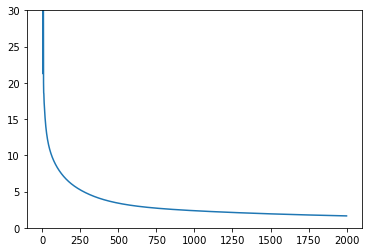

In [329]:
plt.plot(history["train_loss"])
plt.ylim(0, 30)

In [34]:
# model_fn = lambda x: state.apply_fn({"params": state.params}, x)
# model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
# plt.imshow(model_output[0])